# Pairs Traiding through Unsupervised Learning

In [12]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os

tqdm.pandas()

MIN_YEAR= 2014 # 1980
MAX_YEAR=2021
CHUNKS = 10000

FILEPATH = f"./data/historic_characteristics.csv"
FILEPATH_PARQ = f"./data/historic_characteristics_{MIN_YEAR}_{MAX_YEAR}.parquet"
FILEPATH_MOM_PARQ = f"./data/data_mom_{MIN_YEAR}_{MAX_YEAR}.parquet"
FILEPATH_CLEAN_PARQ = f"./data/data_cleaning_{MIN_YEAR}_{MAX_YEAR}.parquet"
FILEPATH_PRE_PARQ = f"./data/data_preprocessed_{MIN_YEAR}_{MAX_YEAR}.parquet"

AGG_CLUSTERS_FILEPATH = f"./data/agg_clusters_data_{MIN_YEAR}_{MAX_YEAR}.pkl"
AGG_CLUSTERS_MEM_FILEPATH = f"./data/agg_clusters_memdata_{MIN_YEAR}_{MAX_YEAR}.pkl"
KM_CLUSTERS_FILEPATH = f"./data/km_clusters_data_{MIN_YEAR}_{MAX_YEAR}.pkl"
KM_CLUSTERS_MEM_FILEPATH = f"./data/km_clusters_memdata_{MIN_YEAR}_{MAX_YEAR}.pkl"
DBS_CLUSTERS_FILEPATH = f"./data/dbs_clusters_data_{MIN_YEAR}_{MAX_YEAR}.pkl"
DBS_CLUSTERS_MEM_FILEPATH = f"./data/dbs_clusters_memdata_{MIN_YEAR}_{MAX_YEAR}.pkl"

SIGNALS_KM_FILEPATH = f"./data/signals_km_{MIN_YEAR}_{MAX_YEAR}.pkl"
SIGNALS_DB_FILEPATH = f"./data/signals_db_{MIN_YEAR}_{MAX_YEAR}.pkl"
SIGNALS_AGG_FILEPATH = f"./data/signals_agg_{MIN_YEAR}_{MAX_YEAR}.pkl"
PCA_FILEPATH = f"./data/pca_{MIN_YEAR}_{MAX_YEAR}.pkl"

FEATURES = [
    "DATE", "absacc", "acc", "aeavol", "age", "agr", "baspread", "beta", "betasq", "bm",
    "bm_ia", "cash", "cashdebt", "cashpr", "cfp", "cfp_ia", "chatoia", "chcsho", "chempia",
    "chinv", "chmom", "chpmia", "chtx", "cinvest", "convind", "currat", "depr", "divi",
    "divo", "dolvol", "dy", "ear", "egr", "ep", "gma", "herf", "hire", "idiovol", "ill",
    "indmom", "invest", "lev", "lgr", "maxret", "mom1m", "ms", "mve_ia", "mvel1", "nincr",
    "operprof", "pchcapx_ia", "pchcurrat", "pchdepr", "pchgm_pchsale", "pchquick",
    "pchsale_pchrect", "pctacc", "permno", "pricedelay", "ps", "quick", "rd", "retvol",
    "roaq", "roeq", "roic", "rsup", "salecash", "salerec", "securedind", "sgr", "sic2",
    "sin", "sp", "std_dolvol", "std_turn", "tang", "tb", "turn", "zerotrade"
]
WINDOW = 48
MOM_FEATURES = [f"mom{i}m" for i in range(1, WINDOW + 1)]

# Data Wrangling

## Parquet Dataset Creation

The dataset is large, around 3GB of company characteristics from 1985 to 2021. This dataset has been currated for the papers ["Empirical Asset Pricing via Machine Learning"](https://dachxiu.chicagobooth.edu/download/ML.pdf)(2018) and ["Autoencoder Asset Pricing Models." ](https://www.sciencedirect.com/science/article/abs/pii/S0304407620301998)(2019) by Shihao Gu, Bryan Kelly and Dacheng Xiu. The raw format is available for download from the authors [personal website](https://sites.google.com/view/agoyal145) (or reach out to me for a currated dataset). The dataset has 94 1 month Lagged Firm Characteristics (as the CRSP releases these with a month delay, from the notes in their papers). Note that this CRSP datasets don't have tickers or company names, but use a permanent indentifier instead, which if you have a bloomberg terminal or access to a research site that brokers this data, you can easily convert to the company ticker.

In [13]:
import pyarrow as pa
import pyarrow.parquet as pq
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd

if not os.path.exists(FILEPATH_PARQ):
    chars_df = pd.read_csv(FILEPATH)[FEATURES]
    chars_df['DATE'] = pd.to_datetime(chars_df['DATE'], format='%Y%m%d')
    chars_df = chars_df[(chars_df['DATE'].dt.year >= MIN_YEAR) & (chars_df['DATE'].dt.year <= MAX_YEAR)]
    chars_df = chars_df.sort_values("DATE")
    chars_df.to_parquet(FILEPATH_PARQ, index=False, compression="snappy")
else:
    chars_df = pd.read_parquet(FILEPATH_PARQ)

chars_df.head(5)

,DATE,absacc,acc,aeavol,age,agr,baspread,beta,betasq,bm,...,sgr,sic2,sin,sp,std_dolvol,std_turn,tang,tb,turn,zerotrade
0,2014-01-31,0.029606,-0.029606,0.305681,27.0,-0.115414,0.029176,0.278519,0.077573,1.072771,...,-0.054436,49.0,0.0,1.201351,0.388992,3.471325,0.477563,-1.245886,1.777459,1.163194e-08
1,2014-01-31,0.005951,-0.005951,-0.616204,14.0,-0.008415,0.022665,0.368354,0.135685,1.547144,...,-0.050507,60.0,0.0,1.230968,0.961516,1.576248,0.559013,NaN,0.392633,5.079101e-08
2,2014-01-31,0.202938,-0.202938,4.920661,13.0,-0.836669,0.053436,1.434001,2.056359,0.088795,...,0.604397,80.0,0.0,0.165907,0.433417,7.329747,0.824576,-0.867492,5.079482,6.478715e-09
3,2014-01-31,0.009347,-0.009347,-0.139907,14.0,-0.032822,0.023961,1.417975,2.010653,0.928146,...,-0.042590,60.0,0.0,0.429145,0.453495,1.122278,0.561790,NaN,0.380723,5.685423e-08
4,2014-01-31,0.052356,-0.052356,1.291097,13.0,0.217583,0.024205,1.279889,1.638115,0.950312,...,-0.200694,36.0,0.0,0.580792,0.342754,2.412849,0.235618,0.142229,1.403505,1.424554e-08


## Sanitization and Feature Engineering

To sanitinize we drop any company with insufficiant data to fill a window, drop columns with insufficient data (>15% nans), and we fill any missing characteristic with the median of that window. We then perform a rolling window to calculate the MOM factor for 2 to 64 months, the data already has a rolling 1 month momentum. To read about momentum stratgies check out the article [Momentum and Reversion Trading Signals Analysis](https://medium.com/call-for-atlas/momentum-and-reversion-the-poor-mans-trading-strategies-9b8e1e6d3496).

Imputting the MOM features for 49 months:

For $i = 1, mom_i = r_{t-1}, \quad i = 1$ where $r_{t-1}$ denotes the return in the previous month.

For $i > 1$, we calculate the momentum over a window of $i$ months is given by:
$$
mom_i = \left( \prod_{j=t-i}^{t-2} (r_j + 1) \right) - 1, \quad i \in \{2, \ldots, 48\},
$$
where \(r_j\) denotes the return in month \(j\).



In [18]:
NAN_THRESHOLD = 0.15

def interpolate_with_median(group):
    rolling_median = group.rolling(window=WINDOW, min_periods=1).median()
    group= group.fillna(rolling_median).bfill()
    return group

if not os.path.exists(FILEPATH_PRE_PARQ):
    valid_groups = chars_df.groupby('permno').filter(lambda x: len(x) >= WINDOW and x[MOM_FEATURES[0]].isna().sum() <= 2)
    for i in tqdm(range(2, WINDOW + 1), desc="moms"):
        rolling_func = lambda x: (x + 1).rolling(window=i).apply(np.prod, raw=True) - 1
        valid_groups[f'mom{i}m'] = valid_groups.groupby('permno')[MOM_FEATURES[0]].transform(rolling_func)

    numerical_columns = valid_groups.select_dtypes(include=['float64', 'int64']).columns

    tqdm.pandas(desc="interpolate_with_median")
    valid_groups[numerical_columns] = valid_groups.groupby('permno')[numerical_columns].progress_transform(lambda x: interpolate_with_median(x))

    nan_percentages = valid_groups[FEATURES].isna().mean()
    valid_groups = valid_groups.drop(columns=nan_percentages[nan_percentages >= NAN_THRESHOLD].index)
    valid_groups = valid_groups.ffill().bfill()

    valid_groups.to_parquet(FILEPATH_PRE_PARQ, index=False, compression="snappy")
    chars_df = valid_groups
else:
    chars_df = pd.read_parquet(FILEPATH_PRE_PARQ)

chars_df.tail(5)

interpolate_with_median: 100%|██████████| 5600/5600 [02:29<00:00, 37.45it/s]


,DATE,aeavol,age,baspread,beta,betasq,bm,bm_ia,cash,cashpr,...,mom39m,mom40m,mom41m,mom42m,mom43m,mom44m,mom45m,mom46m,mom47m,mom48m
4112551,2021-12-31,-0.033631,28.0,0.028294,1.441246,2.077190,0.048185,-0.858778,0.115230,1.092162,...,-0.160019,-0.209986,-0.207510,-0.202510,-0.141996,-0.112534,-0.138494,-0.239209,-0.193775,-0.215214
4112694,2021-12-31,0.151201,37.0,0.022583,0.958245,0.918234,0.344213,-0.082087,0.255362,5.880144,...,0.317601,0.393385,0.390042,0.374003,0.472146,0.450648,0.440951,0.408930,0.429655,0.385778
4112688,2021-12-31,0.151201,37.0,0.016800,1.255085,1.575239,0.344213,-0.082087,0.255362,5.880144,...,0.035717,0.010717,0.021282,0.021282,0.046153,0.132309,0.124301,0.012310,0.044965,0.091738
4112682,2021-12-31,0.151201,37.0,0.008384,0.866276,0.750434,0.344213,-0.082087,0.255362,5.880144,...,0.540994,0.582306,0.625281,0.623059,0.640682,0.665625,0.621044,0.595880,0.640901,0.684288
4117299,2021-12-31,-0.106147,11.0,0.056249,1.504264,2.262812,0.033035,-0.415528,0.329344,32.421935,...,16.967672,17.179807,14.804426,18.036026,17.442083,19.366467,14.799359,14.297700,16.408472,16.549386


## Firm Characteristics

| Acronym  | Firm characteristic                                           | Acronym    | Firm characteristic                                       |
|----------|--------------------------------------------------------------|------------|----------------------------------------------------------|
| absacc   | Absolute accruals                                            | invest     | Capital expenditures and inventory                        |
| acc      | Working capital accruals                                     | IPO        | New equity issue                                          |
| aeavol   | Abnormal earnings announcement volume                        | lev        | Leverage                                                  |
| age      | # years since first Compustat coverage                       | lgr        | Growth in long-term debt                                  |
| agr      | Asset growth                                                  | maxret     | Maximum daily return                                      |
| baspread | Bid-ask spread                                               | ms         | Financial statement score                                 |
| beta     | Beta                                                         | mve        | Size                                                      |
| betasq   | Beta squared                                                 | mve ia     | Industry-adjusted size                                    |
| bm       | Book-to-market                                               | nincr      | Number of earnings increases                              |
| bm ia    | Industry-adjusted book to market                             | operprof   | Operating profitability                                   |
| cash     | Cash holdings                                                | pchcapx ia | Industry adjusted % change in capital expenditures        |
| cashdebt | Cash flow to debt                                            | pchcurrat  | % change in current ratio                                 |
| cashpr   | Cash productivity                                            | pchdepr    | % change in depreciation                                  |
| cfp      | Cash flow to price ratio                                     | pchgm      | % change in gross margin                                  |
| cfp ia   | Industry-adjusted cash flow to price ratio                   | pchsale    | % change in sales                                         |
| chatoia  | Industry-adjusted change in asset turnover                   | pchquick   | % change in quick ratio                                   |
| chcsho   | Change in shares outstanding                                 | pctacc     | Percent accruals                                          |
| chempia  | Industry-adjusted change in employees                        | pricedelay | Price delay                                               |
| chinv    | Change in inventory                                          | ps         | Financial statements score                                |
| chmom    | Change in 6-month momentum                                   | quick      | Quick ratio                                               |
| chpmia   | Industry-adjusted change in profit margin                    | rd         | R&D increase                                              |
| chtx     | Change in tax expense                                        | retvol     | Return volatility                                         |
| cinvest  | Corporate investment                                         | roaq       | Return on assets                                          |
| convind  | Convertible debt indicator                                   | roeq       | Return on equity                                          |
| currat   | Current ratio                                                | roic       | Return on invested capital                                |
| depr     | Depreciation / PP&E                                          | rsup       | Revenue surprise                                          |
| divi     | Dividend initiation                                          | sgr        | Sales growth                                              |
| divo     | Dividend omission                                            | sin        | Sin stocks                                                |
| dolvol   | Dollar trading volume                                        | SP         | Sales to price                                            |
| dy       | Dividend to price                                            | std dolvol | Volatility of liquidity (dollar trading volume)          |
| ear      | Earnings announcement return                                 | std turn   | Volatility of liquidity (share turnover)                  |
| egr      | Growth in common shareholder equity                          | sue        | Unexpected quarterly earnings                             |
| ep       | Earnings to price                                            | tang       | Debt capacity/firm tangibility                            |
| gma      | Gross profitability                                          | tb         | Tax income to book income                                 |
| herf     | Industry sales concentration                                 | turn       | Share turnover                                            |
| hire     | Employee growth rate                                         | zerotrade  | Zero trading days                                         |
| idiovol  | Idiosyncratic return volatility                              |            |                                                           |
| ill      | Illiquidity                                                  |            |                                                           |
| indmom   | Industry momentum                                            |            |                                                           |


Additionally, there are PERMNO columns to ID the company, and a **SIC code** to ID the industry from [NAICS](https://www.naics.com/sic-codes-industry-drilldown/) to compliment the industires momentum **INDMOM**.


For MOM - this is the equities' acceleration measure and is calculated as follows:

$$
\text{MOM}_{\text{1 month}} = \left( \frac{\text{Price at End of Month} - \text{Price at Start of Month}}{\text{Price at Start of Month}} \right) \times 100
$$

Although we don't have a method to convert PERMNO to the actual stock and calculate its price, MOM already provides that change for 1 month.

## Dim Reduction with PCA

We perform standardization and PCA at 95% variance, to center the data's means for the clustering algorithims and reduce its dimensionality.

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

MAX_VARIANCE = 0.99

chars_pca_df = chars_df.copy()
if os.path.exists(PCA_FILEPATH):
    pca_result_df = pd.read_pickle(PCA_FILEPATH)
else:
    scaler = StandardScaler()
    pca = PCA(MAX_VARIANCE)
    features_df = chars_pca_df.drop(['DATE', 'permno'], axis=1).bfill()
    pipeline = Pipeline([('scaler', scaler), ('pca', pca)])
    pca_df = pipeline.fit_transform(features_df)

    pca_result_df = pd.DataFrame(data=pca_df, index=chars_pca_df.index)

    pca_result_df['permno'] = chars_pca_df['permno']
    pca_result_df[MOM_FEATURES] = chars_pca_df[MOM_FEATURES]
    pca_result_df['DATE'] = chars_pca_df['DATE']

    pca_result_df.to_pickle(PCA_FILEPATH)


assert not pca_result_df.isna().any().any()

pca_result_df

,0,1,2,3,4,5,6,7,8,9,...,mom40m,mom41m,mom42m,mom43m,mom44m,mom45m,mom46m,mom47m,mom48m,DATE
3559651,0.071801,-2.243285,-0.525134,-0.325884,0.203386,0.236677,1.586469,-0.308123,0.433157,1.964195,...,0.786379,0.772708,0.718023,0.727186,0.782162,0.703876,0.878869,0.892684,0.934130,2014-01-31
3559649,-3.575163,1.672406,-0.441092,-1.168094,1.236758,-1.174721,0.914891,0.180542,-0.029870,-0.640746,...,-0.392079,-0.423050,-0.415842,-0.376238,-0.409901,-0.390099,-0.362376,-0.386139,-0.427723,2014-01-31
3559647,-0.625475,2.811654,-0.193514,-0.154932,2.333351,-1.982782,-0.841195,-0.118214,-1.043797,-0.340386,...,-0.270833,-0.291667,-0.447917,-0.468750,-0.395833,-0.510417,-0.416667,-0.458333,-0.437500,2014-01-31
3559646,-4.123845,-1.886461,0.270865,-0.878971,1.153939,0.635246,0.898424,0.302249,0.503895,-0.316914,...,0.421559,0.611509,0.121316,0.206487,0.292665,0.224954,0.445938,0.167873,0.402683,2014-01-31
3559645,5.357812,3.047193,3.385119,2.056337,0.652442,-1.298435,-1.476254,-0.253170,-0.928715,0.046023,...,0.559401,0.484947,0.373265,0.617310,0.836536,0.526310,0.824127,0.513901,0.625582,2014-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4112551,-1.923600,-0.462039,-1.021607,2.189858,-0.567304,0.225781,0.840725,-0.265498,0.739643,-0.165025,...,-0.209986,-0.207510,-0.202510,-0.141996,-0.112534,-0.138494,-0.239209,-0.193775,-0.215214,2021-12-31
4112694,0.018709,-1.250392,-1.261624,0.706147,-0.891574,-0.624550,-0.171999,0.079108,1.384809,-0.410376,...,0.393385,0.390042,0.374003,0.472146,0.450648,0.440951,0.408930,0.429655,0.385778,2021-12-31
4112688,1.657183,1.217909,-2.102862,1.773052,-0.486970,-0.818282,-0.270469,-0.275901,0.735712,-0.250709,...,0.010717,0.021282,0.021282,0.046153,0.132309,0.124301,0.012310,0.044965,0.091738,2021-12-31
4112682,2.988199,-0.915106,-2.019969,0.908620,-0.177973,-0.996434,-0.475509,-0.144057,0.400084,-0.221897,...,0.582306,0.625281,0.623059,0.640682,0.665625,0.621044,0.595880,0.640901,0.684288,2021-12-31


# Clustering

In [20]:
from sklearn.neighbors import NearestNeighbors

def distance_to_nearest_neighbors(df, k = 2, alpha = 30):
    """
    Calculates the distance to the nearest neighbors of each point in a DataFrame and determines a distance threshold based on a percentile.

    Computes the L2 nearest neighbors for each point in the dataset.
    It then calculates the average distance to the nearest neighbors, excluding the closest one (itself for k=2), across all points a threshold is used as cut-off distance for clustering or outlier detection.
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the data points.
    - k (int, optional): The number of nearest neighbors to consider. The default is 2 (itself and another).
    - alpha (int, optional): The percentile to use when determining the distance threshold.

    Returns:
    - A tuple containing:
        - NumPy array of distances.
        - Epsilon threshold.
    """

    neigh = NearestNeighbors(n_neighbors=k, n_jobs=-1, metric='l2')
    nbrs = neigh.fit(df)
    distances, _ = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1:].mean(axis=1)
    epsilon = np.percentile(distances, alpha)

    return distances, epsilon

pca_result_df.columns = pca_result_df.columns.astype(str)
pca_components_cols = pca_result_df.drop('DATE', axis=1).columns
pca_components_cols

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       'mom39m', 'mom40m', 'mom41m', 'mom42m', 'mom43m', 'mom44m', 'mom45m',
       'mom46m', 'mom47m', 'mom48m'],
      dtype='object', length=110)

## KMeans

KMeans aims to minimize the sum of square distances between points (eucladien distance) in a two-step tp assign the points (*xi*) to a cluster (*uj*), and then recalculating the clusters' centroids (*uj*) with the means of all the assigned data - iterated until convergence. This is represented as:

$$
J = \sum_{i=1}^{n} \sum_{j=1}^{k} \left\| x_i^{(j)} - \mu_j \right\|^2
$$
Where:
- *n* is the total data points.
- *k* is the total clusters
- *xi^j* is the ith point assigned to the jth cluster
- *uj* is the centroid of the jth cluster.

The problem of kmeans is that it cannot identify outliers, therefore the centroids get skewed. in this case, we will need to find the distances to the centroids, and drop anything larger than the *alpha* threshold of the 2 nearest neighbours.

![by Mohammed Hazim Alkawaz from "Content-based image retrieval using PSO and k-means clustering algorithm"](./Flowchart-of-k-means-clustering-algorithm.png)

In [21]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

def find_optimal_clusters(data, max_clusters=20):
    """
    Identifies the optimal number of clusters using the Silhouette Coefficient.
    We use MiniBatchKMeans to reduce the computation time at the cost of a slight decrease in accuracy.
    See: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html
    Parameters:
    - data: DataFrame containing the data points.
    - max_clusters: Maximum number of clusters to consider.
    Returns:
    - Optimal number of clusters based on the Elbow Method.
    """
    best_score = -1
    best_k = 2
    for n_clusters in range(2, max_clusters + 1):
        km = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', n_init=3, max_iter=100, random_state=1, batch_size=100)
        km.fit(data)
        score = silhouette_score(data, km.labels_)
        if score > best_score:
            best_score = score
            best_k = n_clusters
    return best_k

def distance_to_centroid(km_model, df, alpha=30):
    """
    Calculate the distance from each data point in the provided DataFrame to the centroid of its assigned cluster.
    Parameters:
    - km_model: Fitted KMeans model containing cluster centroids.
    - df: DataFrame containing the data points.
    - a: Optional, alpha max dist percentile to get epsilon threshold.

    Returns:
    - A tuple containing:
        - NumPy array of distances from each data point to its centroid.
        - Epsilon threshold, calculated as the alpha percentile of the L2 distances.
    """
    labels = km_model.labels_
    dist_centroid = km_model.transform(df)
    dist_centroid_member = np.array([dist_centroid[i, labels[i]] for i in range(len(labels))])
    epsilon = np.percentile(dist_centroid_member, alpha)

    return dist_centroid_member, epsilon

def train_km_clusters(pca_result_df, optimal_clusters = None):
    models_dfs = []
    cluster_membership = []
    for month, data in tqdm(pca_result_df.groupby("DATE"), desc="train_km_clusters"):
        pca_data = data[pca_components_cols]
        if len(pca_data) < 2:
            print(f"Skipping {month} due to insufficient data.")
            continue
        if not optimal_clusters:
            optimal_clusters = find_optimal_clusters(pca_data, max_clusters=int(round(np.log(len(pca_data)))))
        km_model = KMeans(n_clusters=optimal_clusters,
                          init='k-means++',
                          n_init=10,
                          max_iter=1000,
                          random_state=1)
        km_model.fit(pca_data)

        # We need to refit and remove the outlier securities.
        dist, eps = distance_to_centroid(km_model, pca_data)
        clean_data = pca_data[~(dist > eps)]
        cluster_df = pd.DataFrame(data['permno'].copy(), index=data.index)
        cluster_df = pd.DataFrame(pca_data['permno'].copy(), index=pca_data.index)
        cluster_df['km_cluster'] = km_model.labels_ if km_model is not None else []
        cluster_df.loc[(dist > eps), "km_cluster"] = -1 # Outliers To be similar to DBScan - we set them to -1
        cluster_df[MOM_FEATURES[0]] = data[MOM_FEATURES[0]]
        cluster_df['DATE'] = month
        cluster_membership.append(cluster_df)

        models_dfs.append({'DATE': month, 'n_clusters': km_model.n_clusters})

    models_df = pd.DataFrame(models_dfs)
    cluster_membership_df = pd.concat(cluster_membership, ignore_index=False)

    return models_df, cluster_membership_df

if os.path.exists(KM_CLUSTERS_FILEPATH) and os.path.exists(KM_CLUSTERS_MEM_FILEPATH) :
    km_models_df = pd.read_pickle(KM_CLUSTERS_FILEPATH)
    km_cluster_membership_df = pd.read_pickle(KM_CLUSTERS_MEM_FILEPATH)
else:
    km_models_df, km_cluster_membership_df = train_km_clusters(pca_result_df, optimal_clusters=500)
    km_models_df.to_pickle(KM_CLUSTERS_FILEPATH)
    km_cluster_membership_df.to_pickle(KM_CLUSTERS_MEM_FILEPATH)

pca_result_df['km_cluster'] = km_cluster_membership_df['km_cluster']
pca_result_df['km_cluster'].tail(5)

train_km_clusters:   0%|          | 0/96 [00:00<?, ?it/s]

train_km_clusters: 100%|██████████| 96/96 [06:46<00:00,  4.23s/it]


4112551     -1
4112694    272
4112688    272
4112682    272
4117299     -1
Name: km_cluster, dtype: int32

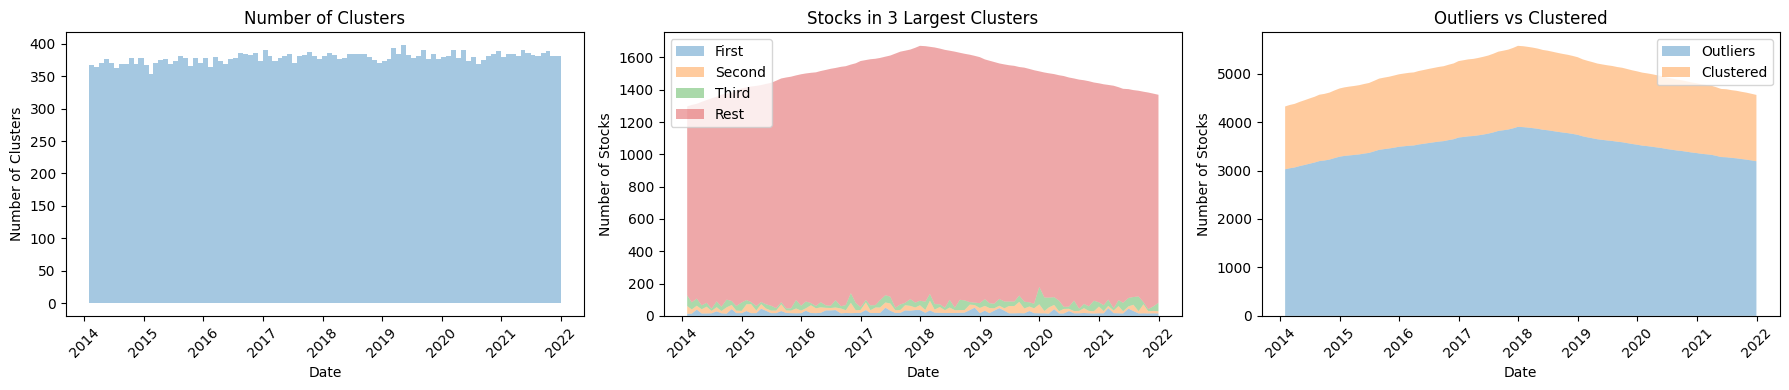

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cluster_distributions(cluster_membership_df, cluster_col):
    """
    Plots the distribution of clusters over time, including a comparison of outliers versus clustered stocks.
    Parameters:
    - cluster_membership_df: DataFrame containing clustering information.
    - cluster_col: String, the name of the column in DataFrame that contains cluster identifiers.
    """



    clusters = cluster_membership_df[cluster_membership_df[cluster_col] > -1].groupby('DATE')[cluster_col].nunique().reset_index()
    clusters['DATE'] = pd.to_datetime(clusters['DATE'])
    cluster_counts = cluster_membership_df.groupby(['DATE', cluster_col])["permno"].count().reset_index()
    cluster_counts['Rank'] = cluster_counts[cluster_counts[cluster_col] > -1].groupby('DATE')["permno"].rank("dense", ascending=False)
    cluster_counts['Cluster_Group'] = cluster_counts.apply(
        lambda row: 'First' if row['Rank'] == 1 else
                    'Second' if row['Rank'] == 2 else
                    'Third' if row['Rank'] == 3 else
                    'Rest', axis=1)
    cluster_counts['Cluster_Group'] = cluster_counts.apply(
        lambda row: 'Outliers' if row[cluster_col] == -1 else
                    row['Cluster_Group'], axis=1)
    cluster_summary = cluster_counts.groupby(['DATE', 'Cluster_Group'])["permno"].sum().unstack(fill_value=0).reset_index()
    cluster_summary['DATE'] = pd.to_datetime(cluster_summary['DATE'])

    fig, axs = plt.subplots(1, 3 if 'Outliers' in cluster_summary.columns else 2, figsize=(18, 4))

    axs[0].fill_between(clusters['DATE'], clusters[cluster_col], step="pre", alpha=0.4)
    axs[0].set_title('Number of Clusters')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Number of Clusters')
    axs[0].tick_params(axis='x', rotation=45)
    axs[1].stackplot(cluster_summary['DATE'],
                     cluster_summary.get('First', pd.Series()),
                     cluster_summary.get('Second', pd.Series()),
                     cluster_summary.get('Third', pd.Series()),
                     cluster_summary.get('Rest', pd.Series()),
                     labels=['First', 'Second', 'Third', 'Rest'], alpha=0.4)
    axs[1].set_title('Stocks in 3 Largest Clusters')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Number of Stocks')
    axs[1].legend(loc='upper left')
    axs[1].tick_params(axis='x', rotation=45)

    if 'Outliers' in cluster_summary.columns:
        clustered_stocks = cluster_summary[['First', 'Second', 'Third', 'Rest']].sum(axis=1)
        outliers = cluster_summary['Outliers']
        axs[2].stackplot(cluster_summary['DATE'], outliers, clustered_stocks, labels=['Outliers', 'Clustered'], alpha=0.4)
        axs[2].set_title('Outliers vs Clustered')
        axs[2].set_xlabel('Date')
        axs[2].set_ylabel('Number of Stocks')
        axs[2].tick_params(axis='x', rotation=45)
        axs[2].legend()

    return fig, axs

plot_cluster_distributions(km_cluster_membership_df, 'km_cluster')
plt.tight_layout()
plt.show()

## DBSCAN

DBSCAN is a Density Based Spatial Clustering or Applications with Noise, that mouthful of a model identifies areas of high interest in high dimensional data, which we have. It is able to handle clusters of arbitrary shapes, and can deal with outliers.

The algo groups together points that are closely packed together within Epsilon (*e*) distance, and assigns a cluster if the number of points are greater than *MinPts*. Clusters are thus areas of high density separated by areas of low density. It will classify points that do not belong to any cluster (further than *e*) as noise.

![by Kecheng Yang from "An ArcGIS add-in for spatiotemporal data mining in climate data"](./Flowchart-of-the-DBSCAN-algorithm.png)

In [29]:
from sklearn.cluster import DBSCAN

def train_db_clusters(pca_result_df):
    models_dfs = []

    cluster_membership = []
    for month, data in tqdm(pca_result_df.groupby("DATE"), desc="train_db_clusters"):
        pca_data = data[pca_components_cols]
        if len(pca_data) < 2:
            print(f"Skipping {month} due to insufficient data.")
            continue

        #MinPts is set to be the natural logarithm of the total number of data points N
        min_samples = int(round(np.log(len(data))))
        _, eps = distance_to_nearest_neighbors(pca_data, k=min_samples + 1,alpha = 30)
        db_model = DBSCAN(eps=eps, metric='l2', min_samples=min_samples)
        db_model.fit(pca_data)

        cluster_df = pd.DataFrame(data['permno'].copy(), index=data.index)
        cluster_df['db_cluster'] = db_model.labels_
        cluster_df['DATE'] = month
        cluster_df[MOM_FEATURES[0]] = data[MOM_FEATURES[0]]

        cluster_membership.append(cluster_df)
        # -1 are the noise points, which we have to remove.
        num_clusters = len(set(db_model.labels_)) - (1 if -1 in db_model.labels_ else 0)

        models_dfs.append({'DATE': month, 'n_clusters': num_clusters})

    models_df = pd.DataFrame(models_dfs)
    cluster_membership_df = pd.concat(cluster_membership, ignore_index=False)

    return models_df, cluster_membership_df

if os.path.exists(DBS_CLUSTERS_FILEPATH) and os.path.exists(DBS_CLUSTERS_MEM_FILEPATH) :
    db_models_df = pd.read_pickle(DBS_CLUSTERS_FILEPATH)
    db_cluster_membership_df = pd.read_pickle(DBS_CLUSTERS_MEM_FILEPATH)
else:
    db_models_df, db_cluster_membership_df = train_db_clusters(pca_result_df)
    db_models_df.to_pickle(DBS_CLUSTERS_FILEPATH)
    db_cluster_membership_df.to_pickle(DBS_CLUSTERS_MEM_FILEPATH)

pca_result_df['db_cluster'] = db_cluster_membership_df['db_cluster']
pca_result_df['db_cluster'].tail(5)

train_db_clusters:   0%|          | 0/96 [00:00<?, ?it/s]

train_db_clusters: 100%|██████████| 96/96 [02:24<00:00,  1.51s/it]


4112551   -1
4112694   -1
4112688   -1
4112682   -1
4117299   -1
Name: db_cluster, dtype: int64

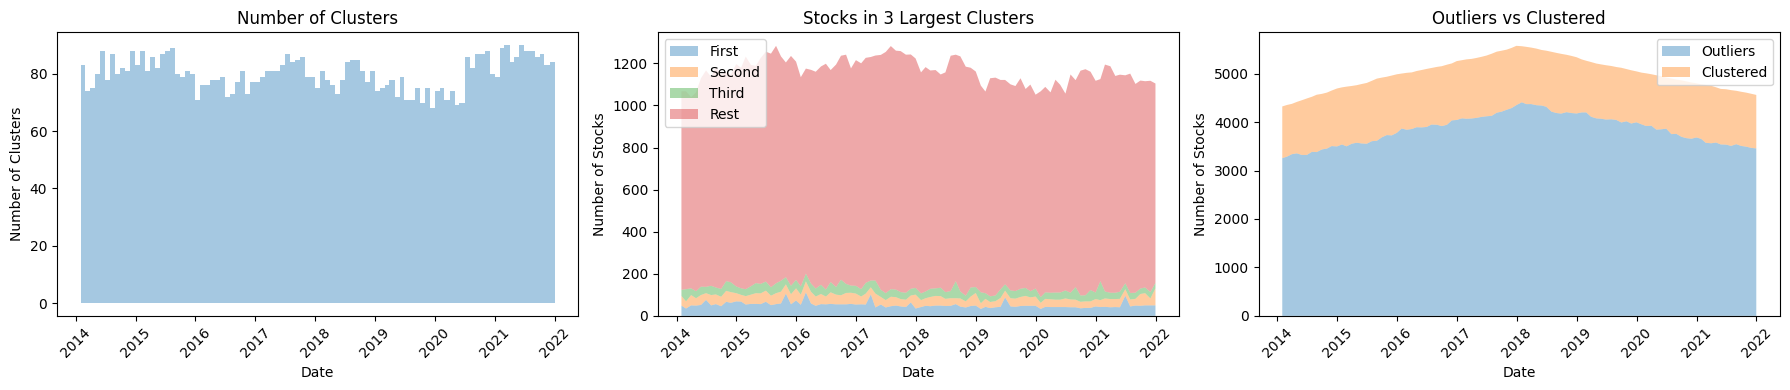

In [30]:
plot_cluster_distributions(db_cluster_membership_df, 'db_cluster')
plt.tight_layout()
plt.show()

## Agglomerative

Agglomerative is a hierarchical cluster algo that work iteratively by merging closest pairs of clusters until it converges to one cluster, or meeting a criterion.

![by Moisés Felipe Silva from "Agglomerative concentric hypersphere clustering applied to structural damage detection"](./Flow-chart-of-agglomerative-hierarchical-clustering.png)

In [31]:
from sklearn.cluster import AgglomerativeClustering

def train_agg_clusters(pca_result_df):
    models_dfs = []

    cluster_membership = []
    for month, data in tqdm(pca_result_df.groupby("DATE"), desc="train_agg_clusters"):
        pca_data = data[pca_components_cols]
        if len(pca_data) < 2:
            print(f"Skipping {month} due to insufficient data.")
            continue

        _, dist_alpha_thresh = distance_to_nearest_neighbors(pca_data, alpha = 30)
        agg_model = AgglomerativeClustering(n_clusters=None, distance_threshold=dist_alpha_thresh, linkage='average')
        agg_model.fit(pca_data)

        cluster_df = pd.DataFrame(data['permno'].copy(), index=data.index)
        cluster_df['agg_cluster'] = agg_model.labels_
        cluster_df['DATE'] = month
        cluster_df[MOM_FEATURES[0]] = data[MOM_FEATURES[0]]

        cluster_membership.append(cluster_df)

        models_dfs.append({'DATE': month, 'n_clusters': agg_model.n_clusters_})

    models_df = pd.DataFrame(models_dfs)
    cluster_membership_df = pd.concat(cluster_membership, ignore_index=False)

    return models_df, cluster_membership_df

if os.path.exists(AGG_CLUSTERS_FILEPATH) and os.path.exists(AGG_CLUSTERS_MEM_FILEPATH) :
    agg_models_df = pd.read_pickle(AGG_CLUSTERS_FILEPATH)
    agg_cluster_membership_df = pd.read_pickle(AGG_CLUSTERS_MEM_FILEPATH)
else:
    agg_models_df, agg_cluster_membership_df = train_agg_clusters(pca_result_df)
    agg_models_df.to_pickle(AGG_CLUSTERS_FILEPATH)
    agg_cluster_membership_df.to_pickle(AGG_CLUSTERS_MEM_FILEPATH)

pca_result_df['agg_cluster'] = agg_cluster_membership_df['agg_cluster']
pca_result_df['agg_cluster'].tail(5)

train_agg_clusters:   0%|          | 0/96 [00:00<?, ?it/s]

train_agg_clusters: 100%|██████████| 96/96 [02:44<00:00,  1.71s/it]


4112551    1555
4112694    1275
4112688     925
4112682     622
4117299    2288
Name: agg_cluster, dtype: int64

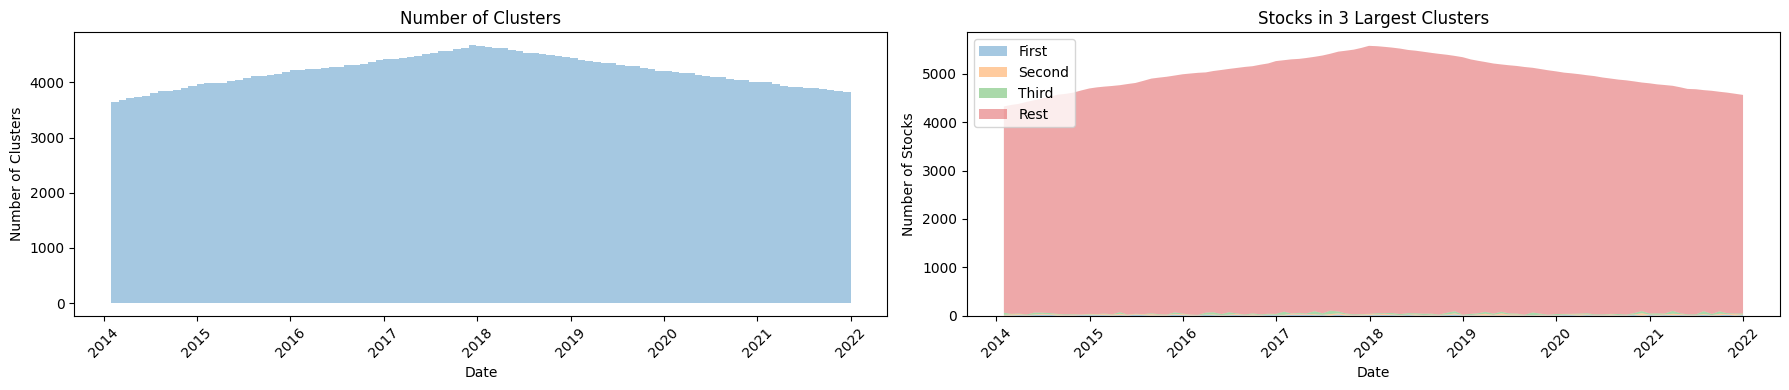

In [32]:
plot_cluster_distributions(agg_cluster_membership_df, 'agg_cluster')
plt.tight_layout()
plt.show()

# Trade Simulation

The trade will take the following steps:
1. Check that the security is in the cluster.
2. Get cross-sectional standard dev.
3. split into deciles.
4. if first > last by > 1 std - there is a statarb opportunity.
5. Select Long-Short for that month, and close securities from previous month which have reversed back to their normal distance.

In [37]:
def statarb_signals(group, std_dev_factor=1):
    overs = unders = []
    if len(group[MOM_FEATURES[0]]) > 1:
        group_sorted = group.sort_values(by=MOM_FEATURES[0], ascending=True).reset_index(drop=True)
        mid_idx = len(group_sorted) // 2
        top_half = group_sorted.iloc[:mid_idx]
        bottom_half = group_sorted.iloc[-mid_idx:].reset_index(drop=True)

        assert len(top_half) == len(bottom_half), f"len mismatch: {len(top_half) } != {len(bottom_half)}"

        # Standard Pairs Strat: Diff top with bottom deciles and check that a deviation exists.
        mom1_std_dev = group[MOM_FEATURES[0]].std()
        mom1_diffs = bottom_half[MOM_FEATURES[0]].values - top_half[MOM_FEATURES[0]].values
        valid_pairs_mask = mom1_diffs > (mom1_std_dev * std_dev_factor)
        overs = bottom_half[valid_pairs_mask]['permno']
        unders = top_half[valid_pairs_mask]['permno']

    return [{
        'DATE': group['DATE_TRADE'].iloc[0],
        'Cluster': group['cluster'].iloc[0],
        'overs': set(overs),
        'unders': set(unders)
    }]

def process_trade_opportunities(df, cluster_label, filepath):
    df['cluster'] = df[cluster_label]

    tqdm.pandas(desc=f"StatArb opportunities with {cluster_label}")
    trade_opportunities = df.groupby(['cluster']).progress_apply(statarb_signals)
    trade_opportunities = [item for sublist in trade_opportunities for item in sublist]
    if len(trade_opportunities) == 0:
        return pd.DataFrame()

    # Statarb needs pairs from top and botton deciles, drop odds or empty
    trade_opportunities_df = pd.DataFrame(trade_opportunities)
    trade_opportunities_df = trade_opportunities_df[
        (trade_opportunities_df['overs'].apply(len) > 0) & (trade_opportunities_df['unders'].apply(len) > 0) & (trade_opportunities_df['overs'].apply(len) == trade_opportunities_df['unders'].apply(len))
    ]

    condition = trade_opportunities_df.progress_apply(lambda row: len(row['overs']) > 0 and len(row['unders']) > 0 and len(row['overs']) == len(row['unders']), axis=1)
    trade_opportunities_df = trade_opportunities_df[condition]

    trade_opportunities_df.to_pickle(filepath)
    return trade_opportunities_df

pca_result_df['DATE_TRADE'] = pca_result_df.groupby('permno')['DATE'].shift(-1).ffill()
if not (os.path.exists(SIGNALS_KM_FILEPATH) and os.path.exists(SIGNALS_DB_FILEPATH) and os.path.exists(SIGNALS_AGG_FILEPATH)):
    trade_opportunities_km_df = process_trade_opportunities(pca_result_df, 'km_cluster', SIGNALS_KM_FILEPATH)
    trade_opportunities_db_df = process_trade_opportunities(pca_result_df, 'db_cluster', SIGNALS_DB_FILEPATH)
    trade_opportunities_agg_df = process_trade_opportunities(pca_result_df, 'agg_cluster', SIGNALS_AGG_FILEPATH)
else:
    trade_opportunities_km_df = pd.read_pickle(SIGNALS_KM_FILEPATH)
    trade_opportunities_db_df = pd.read_pickle(SIGNALS_DB_FILEPATH)
    trade_opportunities_agg_df = pd.read_pickle(SIGNALS_AGG_FILEPATH)

trade_opportunities_km_df.tail(5)

StatArb opportunities with km_cluster:   0%|          | 0/501 [00:00<?, ?it/s]

StatArb opportunities with agg_cluster: 100%|██████████| 2866/2866 [00:00<00:00, 17583.40it/s]


,DATE,Cluster,overs,unders
491,2014-02-28,490,"{13185, 88965, 12679, 14985, 88970, 14987, 149...","{88963, 13191, 13196, 85645, 12684, 80401, 126..."
493,2014-03-31,492,"{64020, 11285, 15898, 10779, 11292, 11293, 845...","{10781, 15903, 15906, 91184, 91186, 92723, 927..."
497,2014-02-28,496,"{17929, 14347, 91176, 71722, 91182, 90685, 906...","{14336, 92672, 14339, 78852, 14342, 78854, 926..."
498,2014-02-28,497,"{13316, 13318, 71175, 14344, 14345, 13319, 143...","{90114, 14339, 13319, 14344, 13322, 13323, 143..."
499,2014-02-28,498,"{65541, 78854, 92679, 92171, 87053, 92173, 921...","{92672, 78852, 92680, 92684, 14862, 92686, 870..."


## PnL

In [38]:
TRADE_FEATURE = ["DATE"]

asset_df = pca_result_df.reset_index()[['DATE', 'permno', MOM_FEATURES[0]]].copy()

monthly_profit_loss = []
overs_df = trade_opportunities_km_df[TRADE_FEATURE +  ['overs']].explode('overs').rename(columns={'overs': 'permno'})
unders_df = trade_opportunities_km_df[TRADE_FEATURE +  ['unders']].explode('unders').rename(columns={'unders': 'permno'})
overs_df = pd.merge(overs_df, asset_df, left_on=['DATE', 'permno'], right_on=['DATE', 'permno'])
unders_df = pd.merge(unders_df, asset_df, left_on=['DATE', 'permno'], right_on=['DATE', 'permno'])

unders_df.tail(5)

,DATE,permno,mom1m
13034,2014-02-28,87508,-0.044597
13035,2014-02-28,13273,0.012817
13036,2014-02-28,87532,-0.006676
13037,2014-02-28,23026,-0.045179
13038,2014-02-28,10232,-0.018651


## Performance

Equal Weighted Returns:

$$
R_p = \sum_{i=1}^{n} (w_i \cdot r_i)
$$

In [39]:
overs_df = overs_df.groupby('DATE')[MOM_FEATURES[0]].mean()
unders_df = unders_df.groupby('DATE')[MOM_FEATURES[0]].mean()
over_ret = overs_df.mul(-1).add(1).cumprod().sub(1)
under_ret = unders_df.add(1).cumprod().sub(1)

over_ret.tail(5)

DATE
2014-02-28   -0.000302
2014-03-31   -0.045984
2014-04-30   -0.046235
2014-06-30   -0.050630
2014-07-31   -0.082339
Name: mom1m, dtype: float64

In [40]:
under_ret.tail(5)

DATE
2014-02-28   -0.000523
2014-03-31    0.049837
2014-04-30    0.047164
2014-06-30    0.066661
2014-07-31    0.135398
Name: mom1m, dtype: float64